#### task:

given gene expression (RNA), predict surface protein levels.

- train/test_cite_inputs.h5: Rows corresponding to cells and columns corresponding to genes given by {gene_name}_{gene_ensemble-ids}
 - have 22085 genes
 - from these: 84 are handselected and hstacked to the right
 - ... and on the remaining 22001 genes, TruncatedSVD is applied -> 128 svd components instead -> hstacked to the left
- train_cite_targets.h5: Surface protein levels for the same cells
 - 140 proteins, e.g. CD36

previous notebooks: compute shap values 
- on svd components + handselected: get shap values of shape (140, n_samples, n_svd_components+84)
- backpropagated attributions to all genes: get attr_all_22085_genes of shape (140, n_samples, 22085)

plotting.ipynb: compare plots for different proteins
now: 
- quantify results in plots
- kl divergence as new metric to order feature importance by

In [1]:
%%capture output
!pip install shap
!pip install anndata
!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import pandas as pd
import os
import random

import shap

import anndata as ad
import scipy
# import scipy.special as sp
import scanpy as sc

from scipy import stats


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
plt.rcParams['figure.dpi'] = 100
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.8 pynndescent==0.5.8


In [4]:
random.seed(42)

In [5]:
os.chdir('../..')

In [6]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/'
index_path = lrz_path + 'open-problems-multimodal-3rd-solution/input/preprocess/cite/'
train_column = np.load(index_path + "train_cite_raw_inputs_idxcol.npz", allow_pickle=True)["columns"]

In [7]:
def get_top_features(shap_values, xtest, top_n):
    shap_sum = np.abs(shap_values).sum(axis=0)
    top_features_indices = np.argsort(shap_sum)[::-1][:top_n]  # Get the indices of the top n features
    top_feature_names_shap = xtest.var_names[top_features_indices]
    return top_feature_names_shap

In [8]:
def get_common_elements(attr, xtest, top_features_considered, min_percentage):
    element_counts = {}

    for i in range(140):
        for elt in get_top_features(attr[i], xtest, top_features_considered):
            element_counts[elt] = element_counts.get(elt, 0) + 1

    # Get the elements that appear in at least min_percentage of the lists
    common_elements = {element for element, count in element_counts.items() if count / 140 >= min_percentage}
    return common_elements

In [9]:
def get_gene_name(last_chars):
    return [element for element in train_column if element.split('_')[1] == last_chars]

### attr_all_22085_genes of model 16

In [10]:
proteins = np.load('4.model/pred/proteins.npy', allow_pickle=True)
def get_protein_idx(protein):
    return np.where(proteins == protein)[0][0]
proteins

array(['CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40',
       'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c',
       'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7', 'CD105', 'CD49f', 'CD194',
       'CD4', 'CD44', 'CD14', 'CD16', 'CD25', 'CD45RO', 'CD279', 'TIGIT',
       'Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b', 'CD20',
       'CD335', 'CD31', 'Podoplanin', 'CD146', 'IgM', 'CD5', 'CD195',
       'CD32', 'CD196', 'CD185', 'CD103', 'CD69', 'CD62L', 'CD161',
       'CD152', 'CD223', 'KLRG1', 'CD27', 'CD107a', 'CD95', 'CD134',
       'HLA-DR', 'CD1c', 'CD11b', 'CD64', 'CD141', 'CD1d', 'CD314',
       'CD35', 'CD57', 'CD272', 'CD278', 'CD58', 'CD39', 'CX3CR1', 'CD24',
       'CD21', 'CD11a', 'CD79b', 'CD244', 'CD169', 'integrinB7', 'CD268',
       'CD42b', 'CD54', 'CD62P', 'CD119', 'TCR', 'Rat-IgG1', 'Rat-IgG2a',
       'CD192', 'CD122', 'FceRIa', 'CD41', 'CD137', 'CD163', 'CD83',
       'CD124', 'CD13', 'CD2', 'CD226', 'CD29', 'CD303', 'CD49b', 'C

In [11]:
xtest_16 = ad.read_h5ad('4.model/pred/private_test_input_128_svd_50_samples.h5ad')
private_test_input_raw = pd.read_pickle('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_test_input_private_raw.pkl')
sample_cells = np.array(xtest_16.obs_names)
xtest_all_genes = private_test_input_raw.loc[sample_cells]

In [12]:
attr_all_22085_genes_16 = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_16_50_samples_p_ct_distr.pkl')
for i in range(len(attr_all_22085_genes_16)):
    attr_all_22085_genes_16[i] = attr_all_22085_genes_16[i].reindex(columns=train_column)

In [12]:
# top_20 = get_top_features(attr_all_22085_genes_16[0], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)
# top_20

In [13]:
# get_top_features(attr_all_22085_genes_16[2], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)

In [14]:
# get_top_features(attr_all_22085_genes_16[3], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)

In [15]:
# top attributing genes across all targets
# get_common_elements(attr_all_22085_genes_16, ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20, 0.75)

### model 17:

In [13]:
xtest_17 = ad.read_h5ad('4.model/pred/private_test_input_64_svd_50_samples.h5ad')
attr_all_22085_genes_17 = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_17_50_samples_p_ct_distr.pkl')
for i in range(len(attr_all_22085_genes_17)):
    attr_all_22085_genes_17[i] = attr_all_22085_genes_17[i].reindex(columns=train_column)

### quantify results from plotting.ipynb: compare gene attr distr to avg distr

spearman correlation and kurtosis variance metric did not work

In [14]:
# sample 20 features 

def sample_features_ranking(attr, protein, gene, top_or_random):
    '''function for sampling the features to be ranked using KL divergence
    top_or_random: 'top' for top20 + gene, 'random' for random 20 + gene
    '''
    df = attr.copy()
   
    # case 1: use top
    if top_or_random == 'top':
        top = get_top_features(df, ad.AnnData(xtest_all_genes, dtype=float), 20)
        if get_gene_name(gene)[0] not in top:  # if specific gene not among the top features but should still be plotted
            top = top.append(pd.Index(get_gene_name(gene)))
        return df[top]
    
    # case 2: use random
    else:
        random_columns = random.sample(df.columns.tolist(), 100)  # 20
        if get_gene_name(gene)[0] not in random_columns:
            random_columns = random_columns + get_gene_name(gene)
        return df[random_columns]

In [15]:
def plot_distr_avg_gene(model_number, protein, gene, show=True):
    ''' plot avg distribution of top columns along with distribution of a specific gene for comparison
    model_number: 16 or 17
    show=True: show plot for specific gene
    show=False: don't show plot, instead print kl divergence for top 20 genes '''
    
    if model_number == 16:
        attr = attr_all_22085_genes_16[get_protein_idx(protein)]
    elif model_number == 17:
        attr = attr_all_22085_genes_17[get_protein_idx(protein)]
    
    # sample features to plot
    df = sample_features_ranking(attr, protein, gene, 'random')  # (top/)random
    
    # Initialize an array to store the sum of histograms
    hist_sum = np.zeros(40)  # 40 bins
    # Calculate the histogram for each column and sum them
    for col in df.columns:
        hist, edges = np.histogram(df[col], bins=40, range=(attr.min().min(), attr.max().max()), density=True)
        hist_sum += hist

    # Divide by the number of columns to average hist_sum
    avg_hist = hist_sum /len(df.columns)
    print(1)
    
    if show:
        # Plot the average histogram
        plt.figure(figsize=(10, 6))
        plt.bar(edges[:-1], avg_hist, width=(edges[1]-edges[0]), label='Avg')
        
        
        # Plot histogram for single gene to be compared
        hist, edges = np.histogram(df[get_gene_name(gene)], bins=40, range=(attr.min().min(), attr.max().max()), density=True)
        # Plot the histogram
        plt.bar(edges[:-1], hist, width=(edges[1]-edges[0]), color='orange', alpha=0.7, label=gene)
    
        # print kl divergence between both distributions
        # add 1e-10 to avoid dividing by 0
        print(np.sum(scipy.special.kl_div(avg_hist+1e-10, hist+1e-10)))
        
        plt.text(0.3, 0.95, f'KL Divergence: {np.sum(scipy.special.kl_div(avg_hist+1e-10, hist+1e-10)):.3f}', ha='center', color='turquoise', fontsize=12, transform=plt.gca().transAxes)
        
        plt.xlabel('Attribution value')
        plt.ylabel('Normalized frequency')
        plt.title(f'Prediction of {protein}: Average distribution and distribution of {get_gene_name(gene)[0]}')
        plt.legend(loc='upper right')
        plt.grid(False)
        plt.show()
#     else:   # wrong logic -> use ranking()
#         # plot top attributing genes by kl divergence:
#         kl_div_list = []
#         for top_gene in df.columns:
#             # compute hist for current gene:
#             hist, _ = np.histogram(df[top_gene], bins=40, range=(attr.min().min(), attr.max().max()), density=True)
            
#             # append kl divergence between the current gene distr and the avg distr to the list
#             kl_div_list.append(np.sum(scipy.special.kl_div(avg_hist+1e-10, hist+1e-10)))
#         print(2)
#         # sort desc by kl divergence
#         sorted_genes, sorted_values = zip(*sorted(zip(df.columns, kl_div_list), key=lambda x: x[1]))
#         print(3)
#         # Create a bar chart
#         plt.figure(figsize=(10, 6))
#         plt.barh(sorted_genes[-20:], sorted_values[-20:])
#         plt.xlabel('KL Divergence Value')
#         plt.ylabel('Top Genes')
#         plt.title(f'Prediction of {protein}: Top attributing genes by KL divergence value')
#         plt.grid(False)
#         plt.tight_layout()
#         plt.show()

In [20]:
# 1. random 20
# 2. compute kl of all genes comparaed to random 20
# 3. rank all genes by kl

def ranking(model_number, protein, random_sample_number):
    ranking_dict = {}
    if model_number == 16:
        attr = attr_all_22085_genes_16[get_protein_idx(protein)]
    elif model_number == 17:
        attr = attr_all_22085_genes_17[get_protein_idx(protein)]
    
    range_attr=(attr.min().min(), attr.max().max())
    
    # average distr.:
    # sample 20 random features to compare to
    df = attr.copy()
    random_columns = random.sample(df.columns.tolist(), random_sample_number)
    df = df[random_columns]

    # Initialize an array to store the sum of histograms
    hist_sum = np.zeros(40)  # 40 bins
    # Calculate the histogram for each column and sum them
    for col in df.columns:
        hist, _ = np.histogram(df[col], bins=40, range=range_attr, density=True)
        hist_sum += hist

    # Divide by the number of columns to average hist_sum
    avg_hist = hist_sum /len(df.columns)
    
    for gene in train_column:
        # histogram for single gene to be compared
        hist, _ = np.histogram(attr[gene], bins=40, range=range_attr, density=True)
        
        # append this gene's kl divergence to ranking_dict
        ranking_dict[gene] = np.sum(scipy.special.kl_div(avg_hist+1e-10, hist+1e-10))  # hist+1e-10, avg_hist+1e-10
        # print(gene, ranking_dict[gene])
    
    sorted_dict = dict(sorted(ranking_dict.items(), key=lambda item: item[1], reverse=True))
    top_20_entries = dict(list(sorted_dict.items())[:19])
    
    # force ground truth gene if exists and not yet in top_20_entries
    try:
        if get_gene_name(protein)[0] not in list(top_20_entries.keys()):
            print(f'manually added gene {protein}')
            top_20_entries[get_gene_name(protein)[0]] = ranking_dict[get_gene_name(protein)[0]]
    except Exception as e:
        print(e)
        print('no')
    
    # plot ranking
    plt.figure(figsize=(10, 6))
    plt.barh(list(top_20_entries.keys())[::-1], list(top_20_entries.values())[::-1])
    plt.ylabel('Top genes')
    plt.xlabel('KL divergence')
    plt.title('Top 20 attributing genes by KL divergence')
    plt.grid(False)
    plt.show()
    
    # plot corresponding beeswarm
    shap.initjs()
    shap.summary_plot(np.array(attr[list(top_20_entries.keys())]), 
                      xtest_all_genes[list(top_20_entries.keys())], 
                      feature_names=list(top_20_entries.keys()))
    return sorted_dict

manually added gene CD7


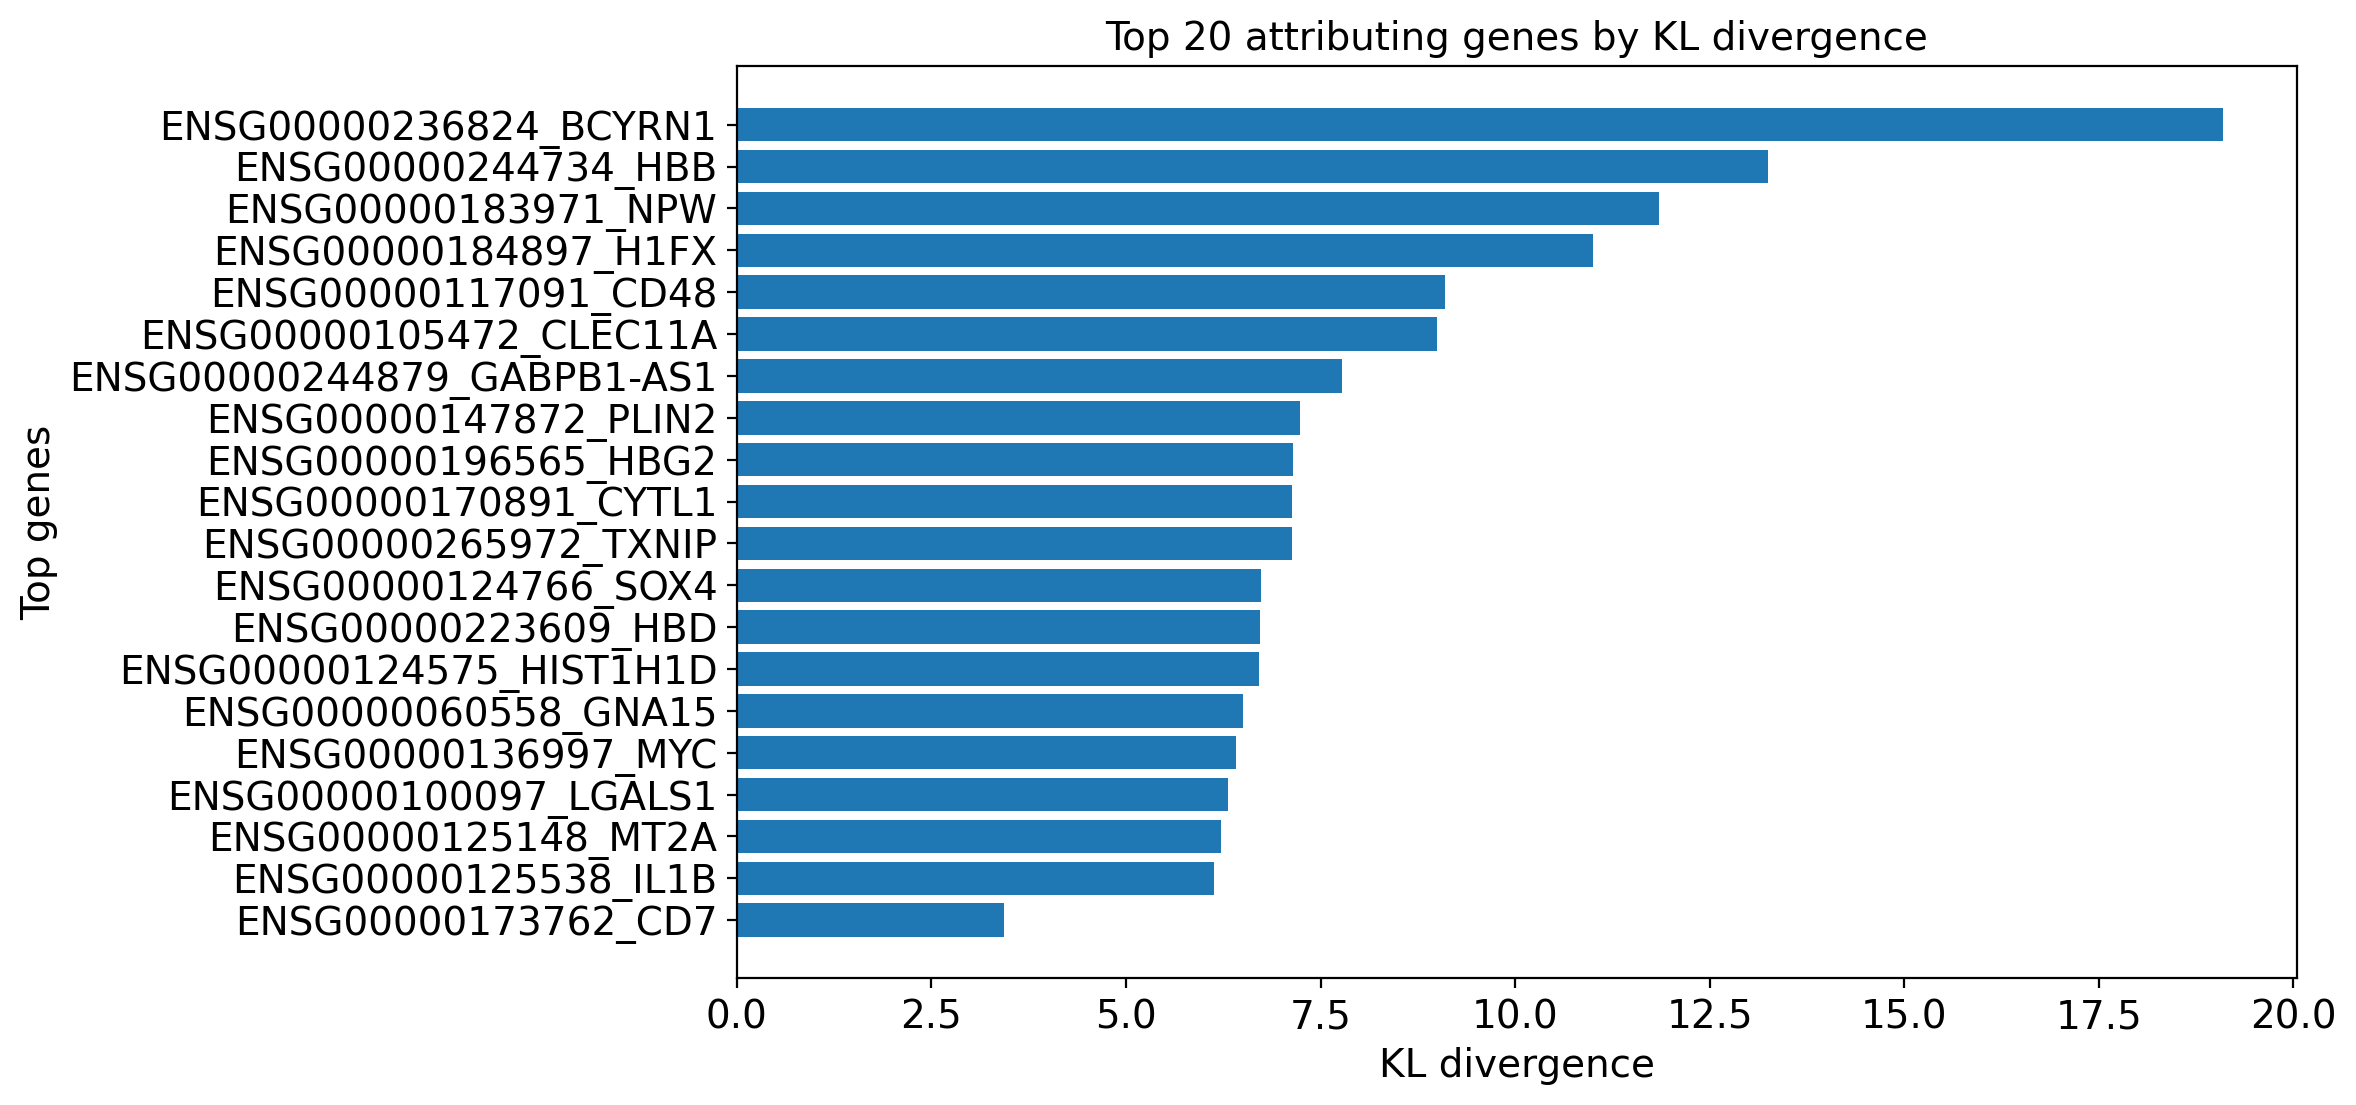

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


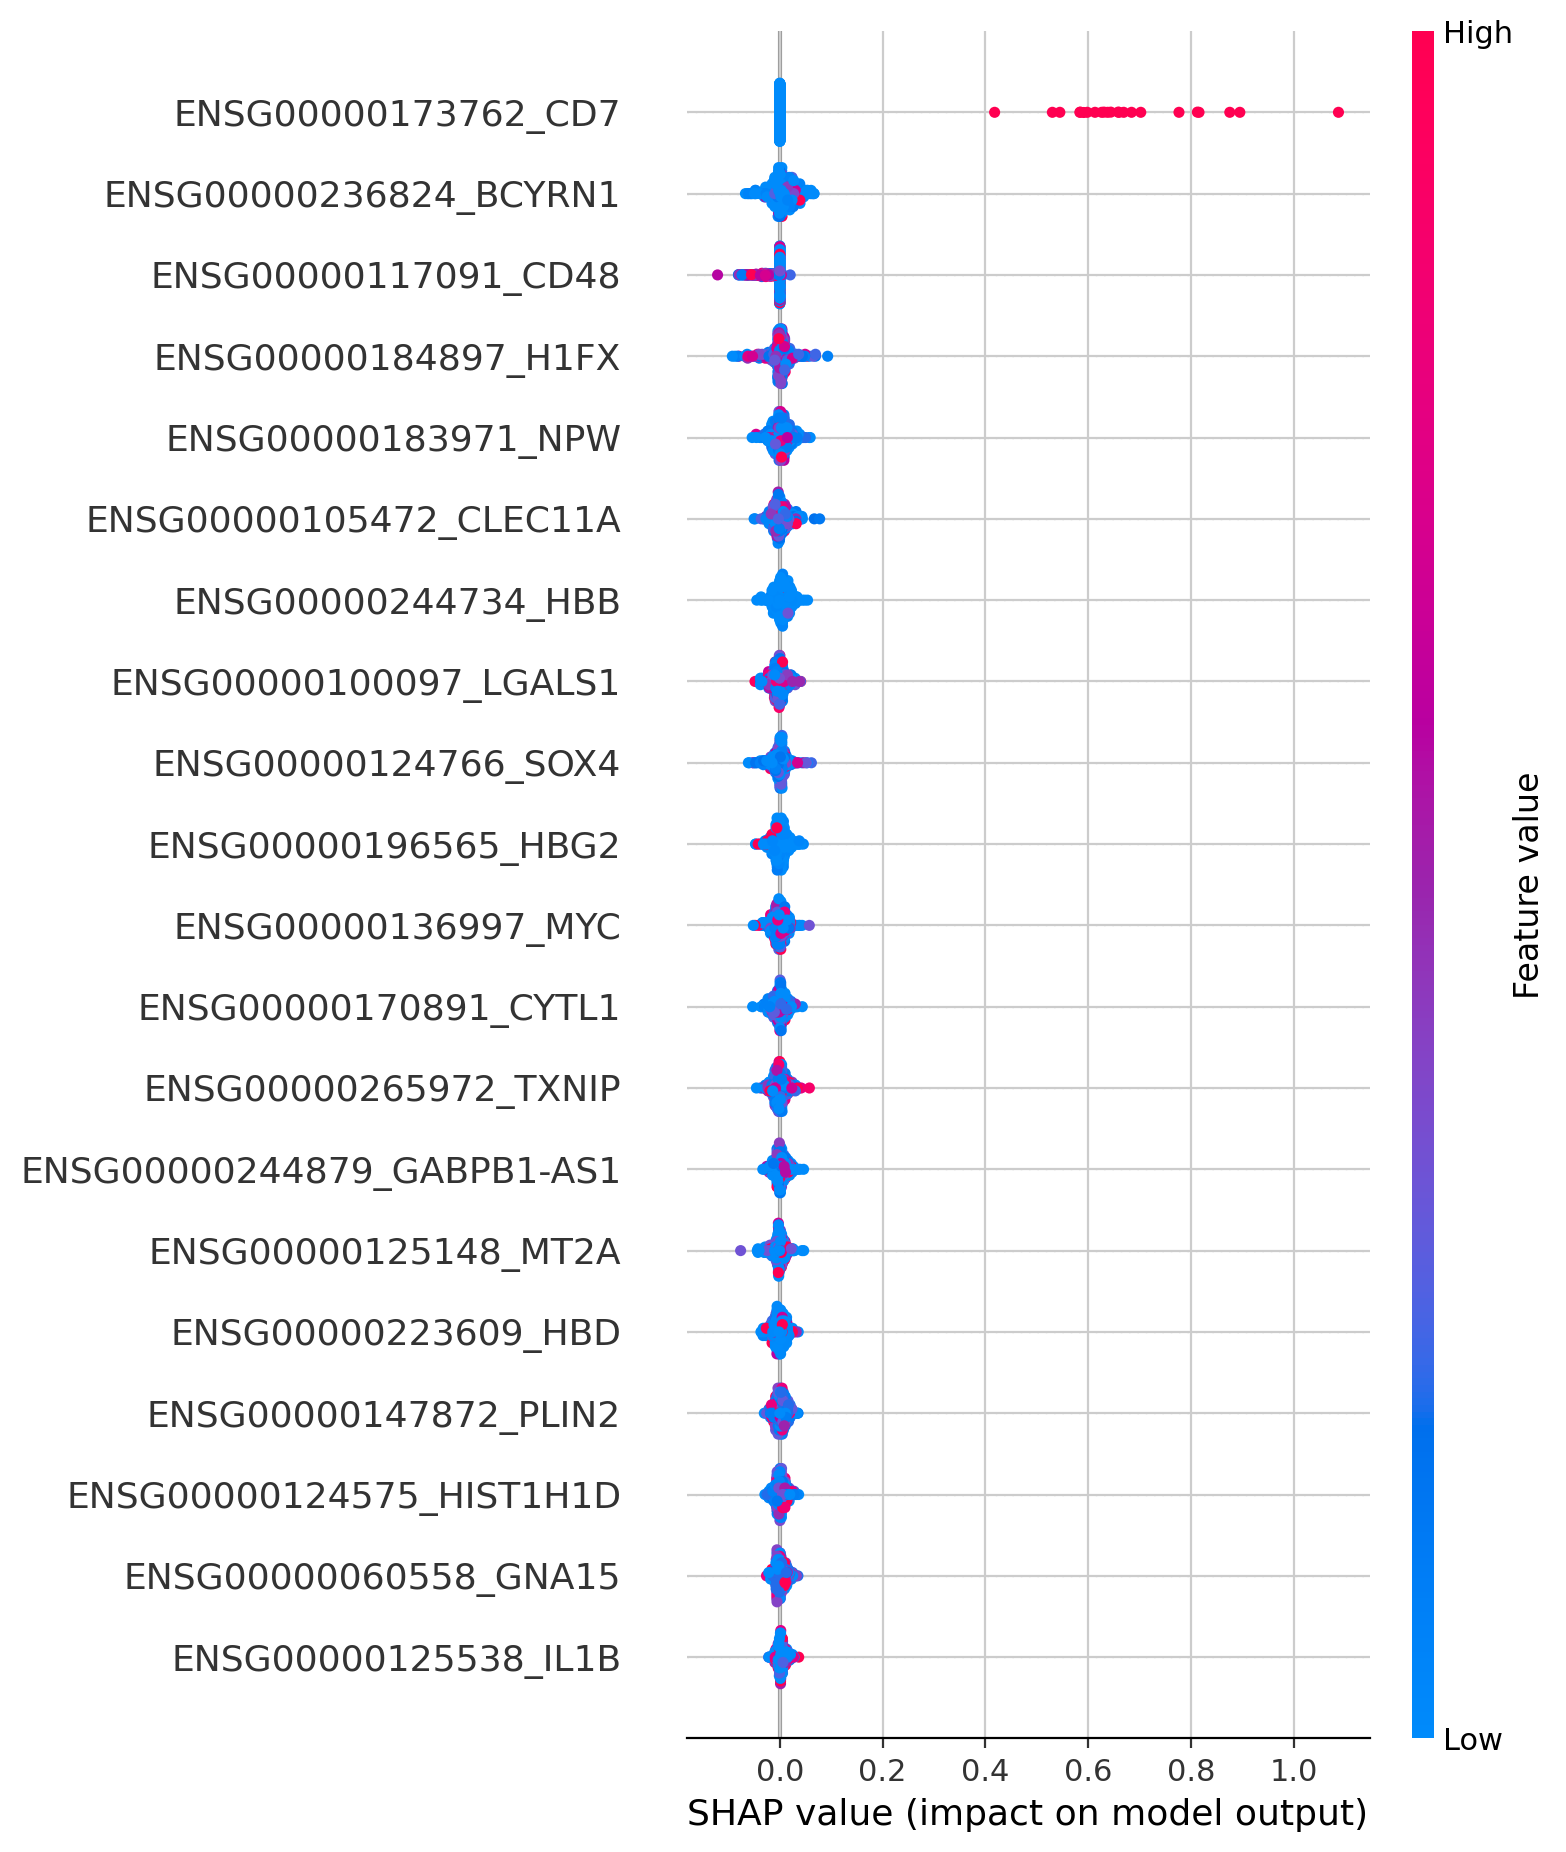

In [27]:
ranked = ranking(16, 'CD7', random_sample_number=100)

In [80]:
# plot_distr_avg_gene(16, 'CD86', 'CD86', show=False)   # decreasing kl divergence for decreasingly important genes

1
306.72029910807646


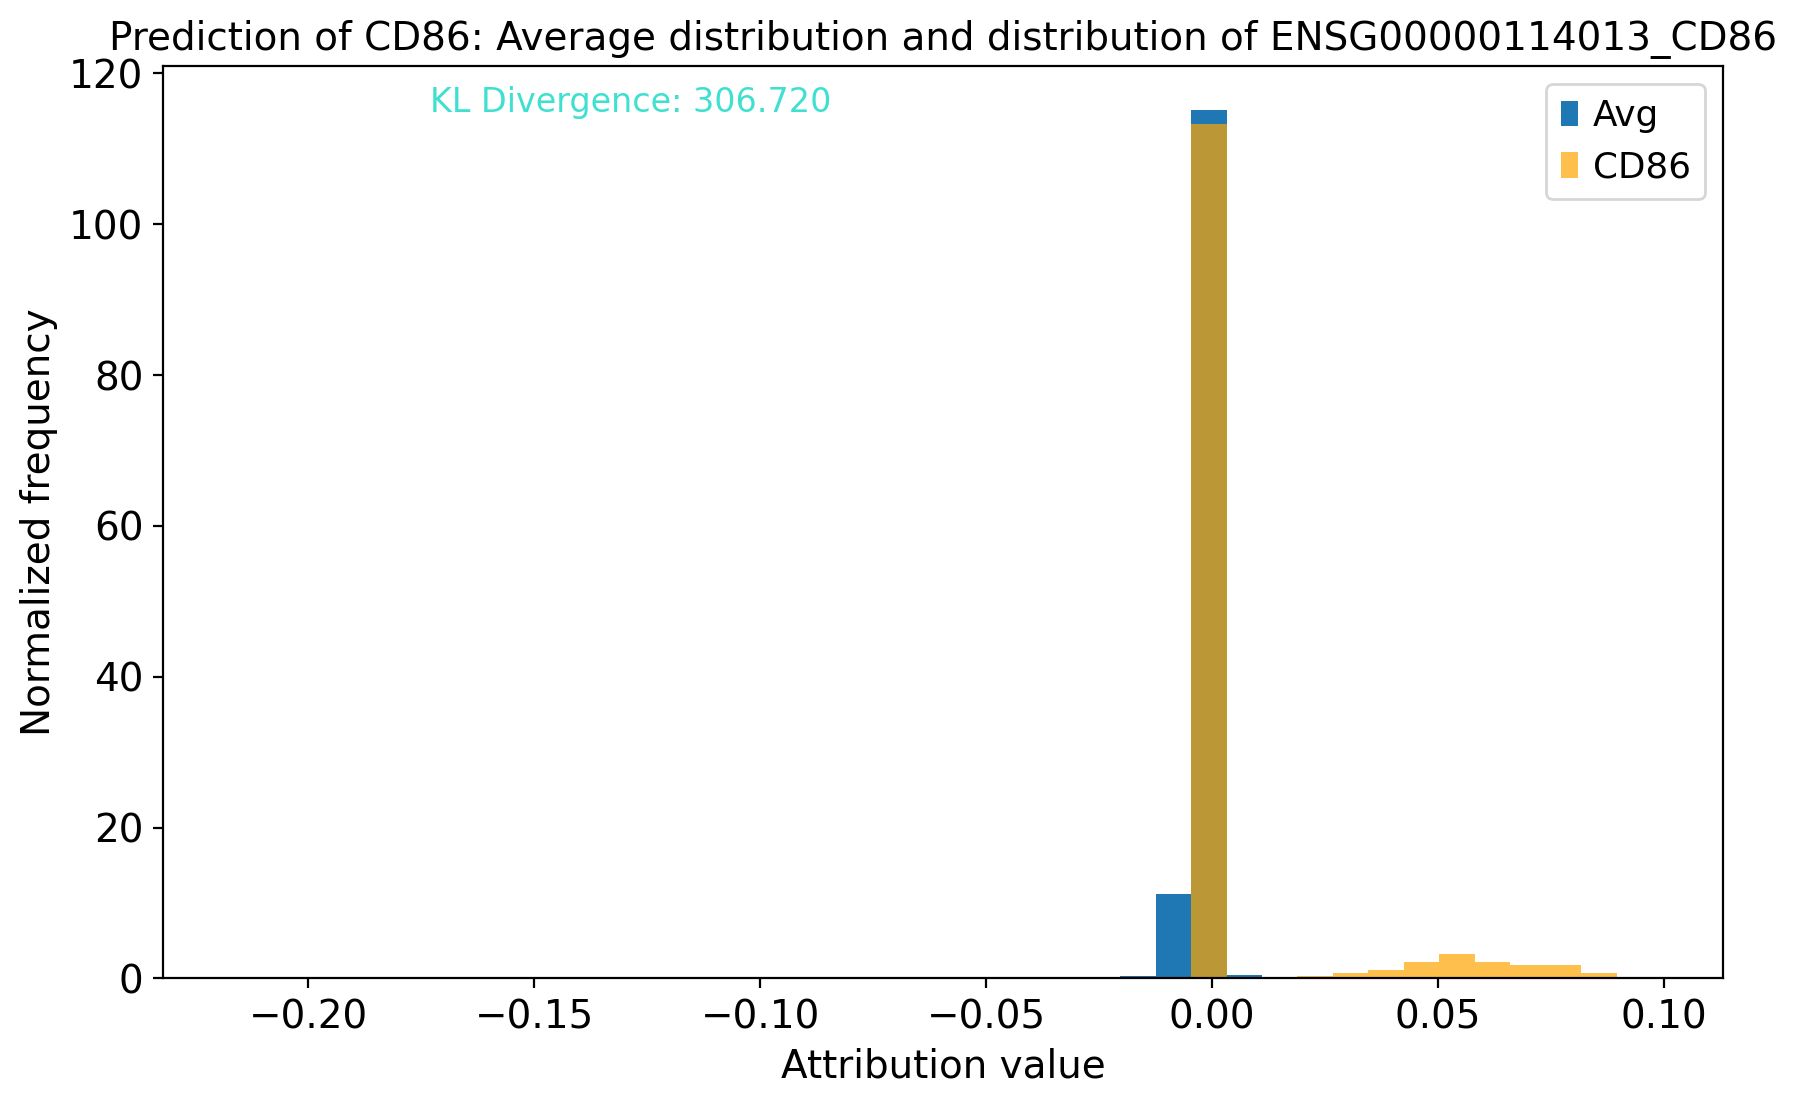

In [22]:
plot_distr_avg_gene(16, 'CD86', 'CD86')   # decreasing kl divergence for decreasingly important genes

In [82]:
# plot_distr_avg_gene(17, 'CD9', 'CD9', show=False) 

### compute mean per cell type

In [ ]:
# moved computing the mean to plotting.ipynb
# TODO move min/max as well? Delete from here?
def mean_per_cell_type(attr_all_genes, xtest, n_top, stat):
    ''' stat: pass mean, min, max, median '''
    top_feature_names_shap = get_top_features(attr_all_genes, xtest, n_top)
    # create df with shap values of top n features + cell type    
    shap_cell_types = {}
    # Add 'Cell Type' column
    shap_cell_types['Cell Type'] = xtest.obs['cell_type']
    # Add attribution values of top n features
    for feature in top_feature_names_shap:
        column_values = np.array(attr_all_genes)[:, xtest.var_names.get_loc(feature)]
        shap_cell_types[feature] = column_values

    # Create DataFrame
    shap_cell_types = pd.DataFrame(shap_cell_types)
    
    if stat == 'mean':
        mean_per_ct = shap_cell_types.groupby('Cell Type').apply(lambda x: x.abs().mean())
        mean_per_ct.reset_index(inplace=True)
        # Calculate the mean across all rows (excluding the 'cell type' column)
        overall_mean = shap_cell_types.drop('Cell Type', axis=1).abs().mean()
        # Add the overall mean as a new row to the DataFrame
        mean_per_ct.loc[len(mean_per_ct)] = ['Overall'] + overall_mean.tolist()
    elif stat == 'min':
        mean_per_ct = shap_cell_types.groupby('Cell Type').min()
        mean_per_ct.reset_index(inplace=True)
        # Calculate the mean across all rows (excluding the 'cell type' column)
        overall_mean = shap_cell_types.drop('Cell Type', axis=1).min()
        # Add the overall mean as a new row to the DataFrame
        mean_per_ct.loc[len(mean_per_ct)] = ['Overall'] + overall_mean.tolist()
    elif stat == 'max':
        mean_per_ct = shap_cell_types.groupby('Cell Type').max()
        mean_per_ct.reset_index(inplace=True)
        # Calculate the mean across all rows (excluding the 'cell type' column)
        overall_mean = shap_cell_types.drop('Cell Type', axis=1).max()
        # Add the overall mean as a new row to the DataFrame
        mean_per_ct.loc[len(mean_per_ct)] = ['Overall'] + overall_mean.tolist()
    elif stat == 'median':
        mean_per_ct = shap_cell_types.groupby('Cell Type').median()
        mean_per_ct.reset_index(inplace=True)
        # Calculate the mean across all rows (excluding the 'cell type' column)
        overall_mean = shap_cell_types.drop('Cell Type', axis=1).median()
        # Add the overall mean as a new row to the DataFrame
        mean_per_ct.loc[len(mean_per_ct)] = ['Overall'] + overall_mean.tolist()
    
    return mean_per_ct

In [23]:
mean_per_cell_type(attr_all_22085_genes_16[121], ad.AnnData(xtest_all_genes, obs=xtest_16.obs, dtype=xtest_all_genes.dtypes), 20, 'mean')

X converted to numpy array with dtype float64


,Cell Type,ENSG00000010278_CD9,ENSG00000135218_CD36,ENSG00000184897_H1FX,ENSG00000101745_ANKRD12,ENSG00000183971_NPW,ENSG00000124766_SOX4,ENSG00000135655_USP15,ENSG00000134283_PPHLN1,ENSG00000100097_LGALS1,...,ENSG00000048649_RSF1,ENSG00000123405_NFE2,ENSG00000197061_HIST1H4C,ENSG00000265972_TXNIP,ENSG00000153310_FAM49B,ENSG00000196565_HBG2,ENSG00000122779_TRIM24,ENSG00000102007_PLP2,ENSG00000102409_BEX4,ENSG00000120686_UFM1
0,BP,0.345274,0.018846,0.051737,0.039328,0.033687,0.036823,0.033996,0.033108,0.033051,...,0.031992,0.031016,0.025575,0.024983,0.029185,0.024222,0.028661,0.030007,0.027691,0.027269
1,EryP,0.136655,0.113294,0.048880,0.032755,0.024259,0.032750,0.032449,0.030773,0.027123,...,0.027026,0.028533,0.024920,0.029520,0.027053,0.028103,0.027073,0.023174,0.023872,0.025537
2,HSC,0.628575,0.003720,0.041991,0.029267,0.025890,0.027528,0.026406,0.026309,0.025042,...,0.024779,0.023181,0.023614,0.022091,0.023756,0.020323,0.022232,0.022526,0.020350,0.021006
3,MasP,0.488781,0.006003,0.074119,0.054235,0.049142,0.048645,0.050635,0.047042,0.042958,...,0.043520,0.040488,0.032411,0.035968,0.039833,0.034853,0.037774,0.036596,0.038255,0.037362
4,MkP,1.239405,0.151076,0.042048,0.029735,0.036852,0.028465,0.027854,0.024181,0.029674,...,0.024302,0.024047,0.037205,0.029547,0.021144,0.026031,0.022427,0.022470,0.023503,0.021102
5,MoP,0.905386,0.076862,0.035039,0.024205,0.034551,0.022506,0.024247,0.020820,0.021402,...,0.020553,0.019382,0.018438,0.026032,0.019703,0.024855,0.019872,0.019583,0.017846,0.018108
6,NeuP,0.120816,0.002167,0.042811,0.028581,0.032344,0.027798,0.028417,0.026207,0.024656,...,0.025707,0.024692,0.027806,0.019985,0.023581,0.024385,0.022459,0.021046,0.020644,0.021603
7,Overall,0.552128,0.053138,0.048089,0.034015,0.033818,0.032073,0.032001,0.029777,0.029129,...,0.028268,0.027334,0.027139,0.026875,0.026322,0.026110,0.025785,0.025057,0.024595,0.024570


In [24]:
mean_per_cell_type(attr_all_22085_genes_17[121], ad.AnnData(xtest_all_genes, obs=xtest_16.obs, dtype=xtest_all_genes.dtypes), 20, 'mean')

X converted to numpy array with dtype float64


,Cell Type,ENSG00000010278_CD9,ENSG00000265972_TXNIP,ENSG00000183971_NPW,ENSG00000245532_NEAT1,ENSG00000094916_CBX5,ENSG00000136997_MYC,ENSG00000044574_HSPA5,ENSG00000143013_LMO4,ENSG00000078596_ITM2A,...,ENSG00000167552_TUBA1A,ENSG00000102409_BEX4,ENSG00000122033_MTIF3,ENSG00000196565_HBG2,ENSG00000178057_NDUFAF3,ENSG00000204482_LST1,ENSG00000106211_HSPB1,ENSG00000145734_BDP1,ENSG00000124575_HIST1H1D,ENSG00000125148_MT2A
0,BP,0.293941,0.231850,0.198248,0.155329,0.130741,0.126863,0.125929,0.122794,0.117860,...,0.112670,0.098918,0.106017,0.091842,0.098702,0.098096,0.089925,0.090540,0.090772,0.093812
1,EryP,0.124157,0.129876,0.086183,0.079545,0.060917,0.059710,0.055760,0.063996,0.053548,...,0.053986,0.044191,0.057913,0.046473,0.051913,0.048726,0.042566,0.040312,0.047756,0.051388
2,HSC,0.568469,0.430292,0.341437,0.285482,0.233227,0.238491,0.227086,0.225480,0.222682,...,0.203747,0.197696,0.172369,0.181114,0.173962,0.167285,0.171668,0.168320,0.162547,0.162312
3,MasP,0.434178,0.326899,0.260674,0.212424,0.177440,0.186249,0.177976,0.172126,0.170661,...,0.160300,0.140823,0.137024,0.139454,0.134918,0.134517,0.132241,0.126937,0.123228,0.125258
4,MkP,1.236105,0.895884,0.744280,0.609649,0.497699,0.495432,0.492131,0.480927,0.473684,...,0.417701,0.368282,0.374562,0.363765,0.371411,0.356967,0.360712,0.349660,0.346803,0.329207
5,MoP,0.791599,0.594043,0.474342,0.388421,0.328184,0.322209,0.317058,0.303555,0.301773,...,0.285850,0.265025,0.238529,0.243680,0.247346,0.231643,0.230466,0.235372,0.218919,0.227178
6,NeuP,0.111354,0.102498,0.074488,0.072055,0.060078,0.057457,0.056074,0.055178,0.049452,...,0.047724,0.065103,0.042809,0.051863,0.039454,0.042620,0.041127,0.039202,0.047130,0.038525
7,Overall,0.508543,0.387334,0.311379,0.257558,0.212612,0.212344,0.207430,0.203437,0.198523,...,0.183140,0.168577,0.161317,0.159742,0.159672,0.154265,0.152672,0.150049,0.148165,0.146811
